In [1]:
import keras 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers

In [3]:
folder = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7F2E502EDCC0>


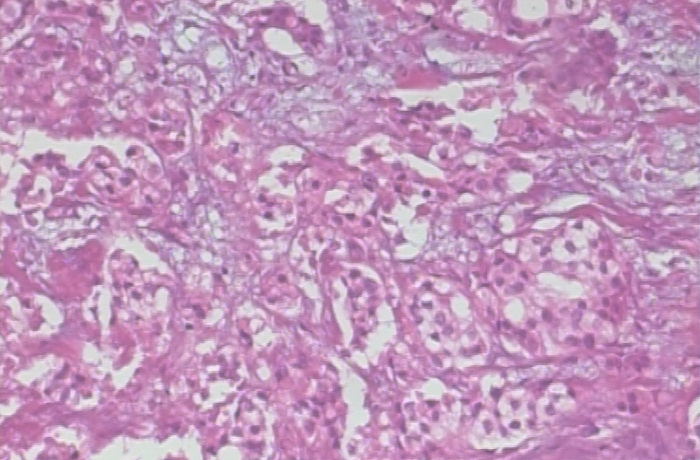

In [4]:
photo = load_img('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-020.png')
print(photo)
photo

In [5]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [6]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=[0.8, 1.2], zoom_range=[.99, 1.01], data_format="channels_last", fill_mode="constant", horizontal_flip=True)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=7909, shuffle=False)

Found 7909 images belonging to 2 classes.


In [7]:
train_data_gen.class_indices

{'benign': 0, 'malignant': 1}

In [8]:
train_data, train_labels = train_data_gen.next()

In [9]:
#Synthetic Minority Over-sampling Technique
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(10858, 49152) (10858, 1)


In [10]:
train_data = train_data.reshape(-1, 128, 128, 3)
print(train_data.shape, train_labels.shape)

(10858, 128, 128, 3) (10858, 1)


In [11]:
train_labels = train_labels.reshape(-1, 1)

In [12]:
# train validation test split
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
test_data, val_data, test_labels,val_labels = train_test_split(test_data, test_labels, test_size = 0.5, random_state=42)

In [13]:
%config InteractiveShellApp.iopub_msg_rate_limit = 2000

In [14]:
# Create the CNN model
model = Sequential([

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Dropout(0.5),
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(64,activation='relu'),
    
    Dense(32,activation='relu'),
    
    Dense(16,activation='relu'),
    
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Fit the model to the training data
history = model.fit(train_data, train_labels, epochs=100, verbose=1, validation_data=(val_data,val_labels), batch_size=100)

Epoch 1/100


2024-01-20 03:42:52.626680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 15s 85ms/step - loss: 0.5856 - accuracy: 0.6951 - val_loss: 0.5235 - val_accuracy: 0.7477
Epoch 2/100
87/87 [==============================] - 6s 68ms/step - loss: 0.4662 - accuracy: 0.7981 - val_loss: 0.4916 - val_accuracy: 0.7882
Epoch 3/100
87/87 [==============================] - 6s 68ms/step - loss: 0.4625 - accuracy: 0.8000 - val_loss: 0.4839 - val_accuracy: 0.7772
Epoch 4/100
87/87 [==============================] - 6s 67ms/step - loss: 0.4465 - accuracy: 0.8121 - val_loss: 0.4546 - val_accuracy: 0.7993
Epoch 5/100
87/87 [==============================] - 6s 67ms/step - loss: 0.4418 - accuracy: 0.8074 - val_loss: 0.4736 - val_accuracy: 0.7974
Epoch 6/100
87/87 [==============================] - 6s 67ms/step - loss: 0.4305 - accuracy: 0.8140 - val_loss: 0.4656 - val_accuracy: 0.8066
Epoch 7/100
87/87 [==============================] - 6s 67ms/step - loss: 0.4196 - accuracy: 0.8178 - val_loss: 0.4435 - val_accuracy: 0.7965
Epoch 8/100
87/87

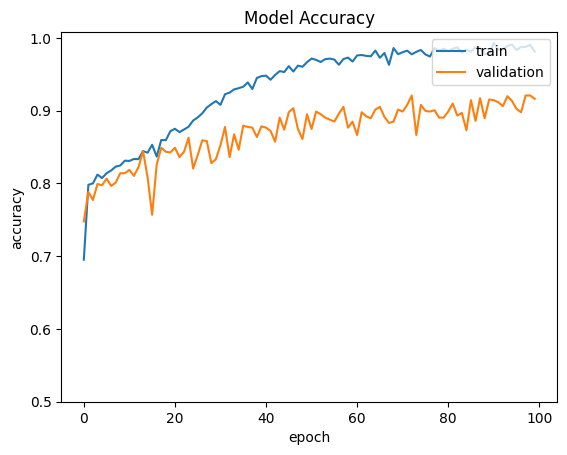

In [17]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(bottom=0.5)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

34/34 [==============================] - 1s 10ms/step


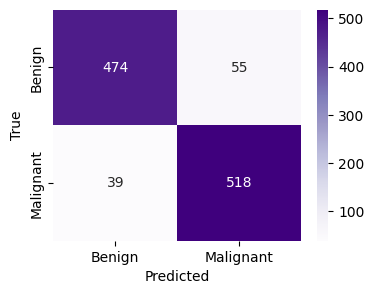

Precision: 0.9040139616055847
Recall: 0.9299820466786356


In [18]:
y_pred = np.round(model.predict(test_data)).astype(int)

cm= confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

true_positive = cm[1, 1]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precision:", precision)
print("Recall:", recall)

In [19]:
r=model.evaluate(test_data,test_labels,batch_size=128)
print('test loss', r[0])
print('test acc', r[1])

9/9 [==============================] - 1s 49ms/step - loss: 0.3594 - accuracy: 0.9134
test loss 0.35937345027923584
test acc 0.9134438037872314


34/34 [==============================] - 0s 6ms/step


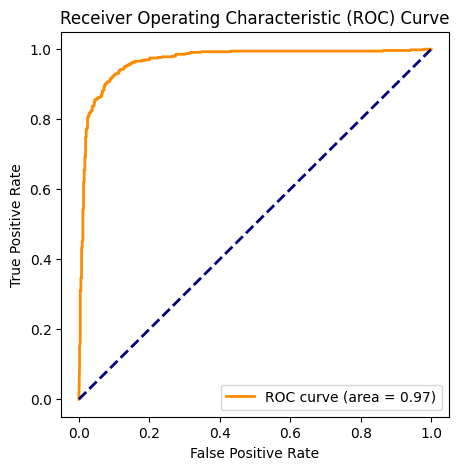

In [20]:
from sklearn.metrics import roc_curve, auc

# Assuming 'model' is your trained model
y_score = model.predict(test_data).ravel()

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(test_labels, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()